# Update Keras and Tensorflow

In [ ]:

!pip install keras==2.3.1
!pip install tensorflow==2.2

     |████████████████████████████████| 378kB 9.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 43.3MB/s 
     |████████████████████████████████| 3.0MB 42.1MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


# Load Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
import re
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model

from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from numpy import array
from random import sample

# Prepare caption data

In [ ]:
text_dict = {}
# each key in text_dict is the name of an image
# each value in text_dict is a list of 5 captions for the image
# each caption has punctuation and single letter words removed and is all lowercase
# each caption starts with 'startseq' and ends with 'endseq'
with open('/content/drive/My Drive/flickr_30k/captions.txt', 'r') as f:
  for line in f.readlines()[1:]:
    caption = []
    line = line.split('|')
    title = line[0].replace('.jpg','')
    # strip whitespace from the caption
    caption = line[2].strip()
    caption = re.sub(r'[^\w\s]','',caption)
    caption = caption.lower()
    caption = caption.split(' ')
    caption = [word for word in caption if len(word) > 1]
    caption = ['startseq'] + caption + ['endseq']
    caption =  ' '.join(caption)
    if title in text_dict:
      text_dict[title] = text_dict[title] + [caption]
    else:
      text_dict[title] = [caption]

# Split data into training, validation and test sets

In [ ]:
# need to split data into training test and validation sets
image_list = list(text_dict.keys())

train_validate, test = train_test_split(image_list, test_size=0.2, random_state=44)
#using 0.25 so validate and test have same number of images
train, validate = train_test_split(train_validate, test_size=0.25, random_state=44)

print("Train length = {}, Validate length = {}, Test length = {}".format(len(train), len(validate), len(test)))

Train length = 19069, Validate length = 6357, Test length = 6357


In [ ]:
# these are the features extracted from the images using the CNN in part 1
features = pickle.load(open('/content/drive/My Drive/flickr_30k/features.pkl', 'rb'))

In [ ]:
# split the descriptions and features into training, validation and test sets
train_features =  {k: features[k] for k in train}
validate_features =  {k: features[k] for k in validate}
test_features =  {k: features[k] for k in test}

train_descriptions = {k: text_dict[k] for k in train}
validate_descriptions = {k: text_dict[k] for k in validate}
test_descriptions = {k: text_dict[k] for k in test}

# Data Prep for Model
In the next part, we want to create 3 arrays. The first is the image features, the second is a  list of the tokenized input sequence containing the first n words of the description of the corresponding image in the first array, and the third array is the n+1 word of the description.   
  
Each of the I image has 5 captions and every caption will be used L times, where L is the length of the longest image cpation. Therefore there will be I * 5 * L values in each array 

In [ ]:
# use Keras Tokenizer to encode words
train_words = list(train_descriptions.values())
train_words2 = [j for i in train_words for j in i]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_words2)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# find the max length of any description
# will pad all input sequences to this length
max_len = max(max(len(j.split(' ')) for j in i ) for i in train_words)

In [ ]:
# this function takes in a list of image names 
# for each image it outputs an array of the image features (from the CNN),
# an array of the input sequence and an array of the output sequence, where
# the input is the first n words of the sequence and the output is the n+1 word
def rnn_input_prep(image_list):
  image_features, input_seq, output_seq = [],[],[]
  # feed images to NN in different order each epoch
  image_list_shuffle = sample(image_list, len(image_list))
  for key in image_list_shuffle:
    for desc in train_descriptions[key]:
      token = tokenizer.texts_to_sequences([desc])[0]
      for i in range(1,len(token)):
        image_features.append(train_features[key][0])
        
        input = token[0:i]
        input = pad_sequences([input],maxlen=max_len)[0]
        input_seq.append(input)
        
        output = token[i]
        output = to_categorical([output], num_classes=vocab_size)[0]
        output_seq.append(output)

  return array(image_features), array(input_seq), array(output_seq)

In [ ]:
# not enough memory, need to use data generator
# each image list set will have 100 images
def data_generator(image_set_list):
	# loop for ever over every set of images
	while 1:
		for image_list in image_set_list:
			# retrieve the photo feature
			in_img, in_seq, out_word = rnn_input_prep(image_list)
			yield [[in_img, in_seq], out_word]

In [ ]:
# split the list of training images into lists of 100 images to use as input to the data generator
train_image_list = list(train_descriptions.keys())
train_image_list_split = [train_image_list[i:i + 100] for i in range(0, len(train_image_list), 100)]

In [ ]:
generator = data_generator(train_image_list_split)
inputs, outputs = next(generator)

(5588, 4096)
(5588, 70)
(5588, 16208)


# Train models with 3 different layer sizes
## First, layer size 256

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 70, 256)      4149248     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 4096)         0           input_5[0][0]                    
____________________________________________________________________________________________

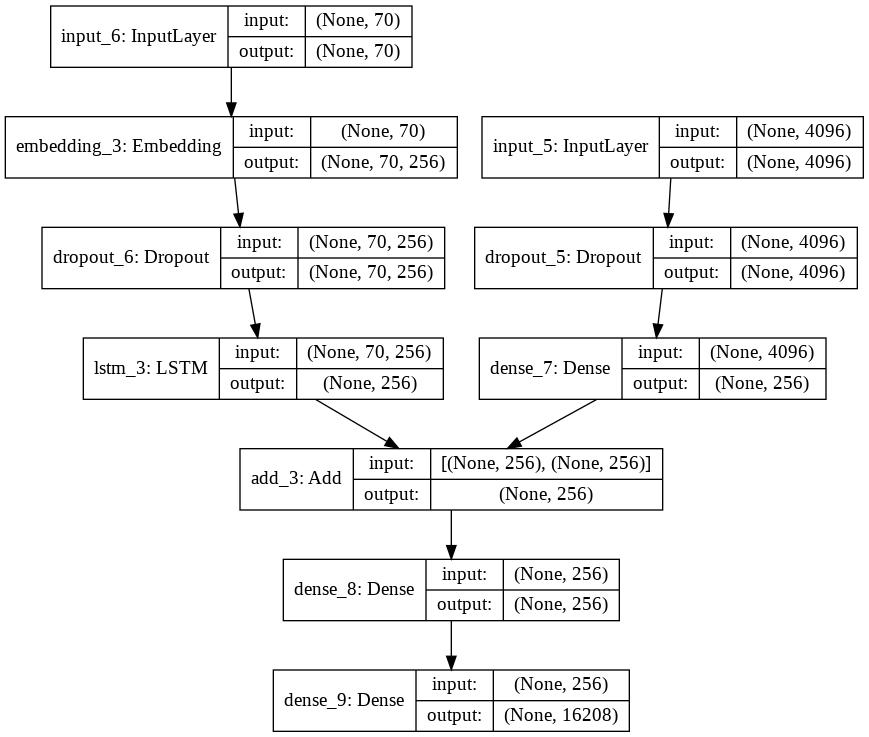

In [ ]:
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_len,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, show_shapes=True)


In [ ]:
epochs = 20
steps = len(train_image_list_split)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_image_list_split)
	# fit for one epoch
	model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model (this is a typo should be 128 not 126)
	model.save('/content/drive/MyDrive/flickr_30k/RG_trial_models/model_v1_111920' + str(i) + '.h5')

## Now layer size 128

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 128)      2074624     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

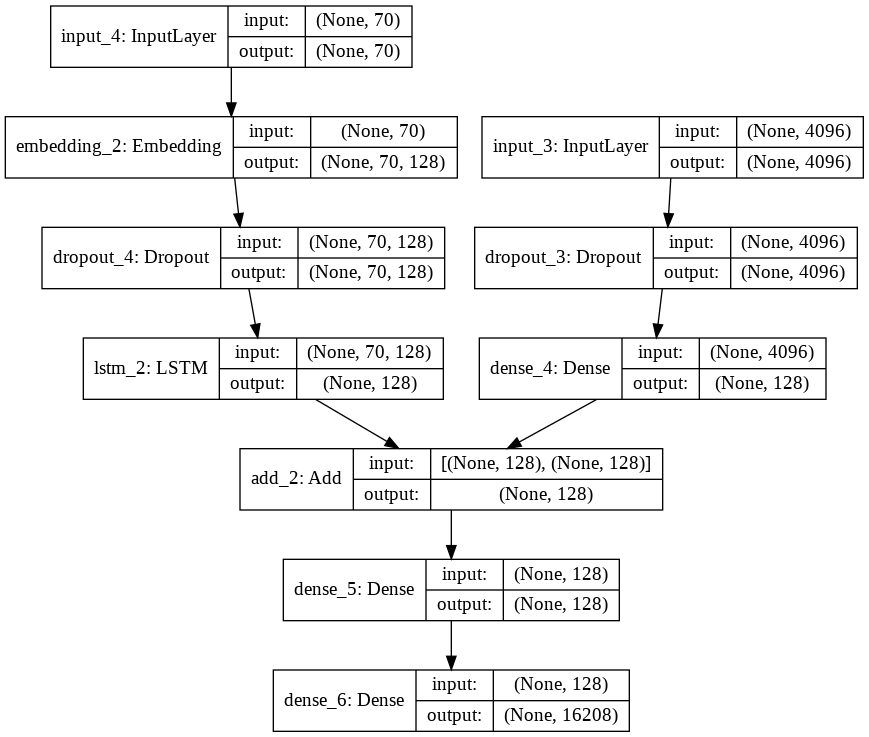

In [ ]:
	# build a model using layer size of 128
  # feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(128, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_len,))
	se1 = Embedding(vocab_size, 128, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(128)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(128, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, show_shapes=True)


In [ ]:
epochs = 20
steps = len(train_image_list_split)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_image_list_split)
	# fit for one epoch
	model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model (this is a typo should be 128 not 126)
	model.save('/content/drive/MyDrive/flickr_30k/RG_trial_models/model_126_112820_' + str(i) + '.h5')

Epoch 1/1
191/191 [==============================] - 138s 723ms/step - loss: 5.7244
Epoch 1/1
191/191 [==============================] - 137s 718ms/step - loss: 4.6557
Epoch 1/1
191/191 [==============================] - 139s 725ms/step - loss: 4.2264
Epoch 1/1
191/191 [==============================] - 138s 722ms/step - loss: 4.0171
Epoch 1/1
191/191 [==============================] - 136s 712ms/step - loss: 3.8766
Epoch 1/1
191/191 [==============================] - 136s 712ms/step - loss: 3.7655
Epoch 1/1
191/191 [==============================] - 135s 709ms/step - loss: 3.6742
Epoch 1/1
191/191 [==============================] - 135s 709ms/step - loss: 3.5978
Epoch 1/1
191/191 [==============================] - 135s 708ms/step - loss: 3.5335
Epoch 1/1
191/191 [==============================] - 135s 706ms/step - loss: 3.4784
Epoch 1/1
191/191 [==============================] - 136s 710ms/step - loss: 3.4304
Epoch 1/1
191/191 [==============================] - 136s 712ms/step - loss:

# Now, layer size 512

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 70, 512)      8298496     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 4096)         0           input_5[0][0]                    
____________________________________________________________________________________________

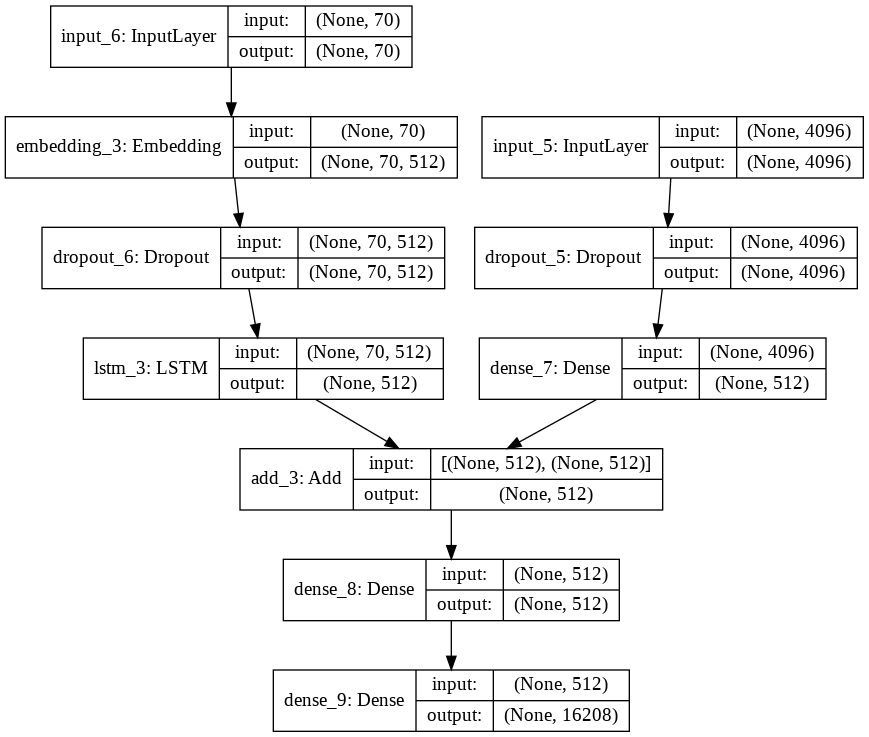

In [ ]:
	# build a model using layer size of 512
  # feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(512, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_len,))
	se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(512)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(512, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, show_shapes=True)


In [ ]:
epochs = 20
steps = len(train_image_list_split)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_image_list_split)
	# fit for one epoch
	model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('/content/drive/MyDrive/flickr_30k/RG_trial_models/model_512_112820_' + str(i) + '.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
191/191 [==============================] - 391s 2s/step - loss: 5.3310
Epoch 1/1
191/191 [==============================] - 392s 2s/step - loss: 4.0780
Epoch 1/1
191/191 [==============================] - 393s 2s/step - loss: 3.7007
Epoch 1/1
191/191 [==============================] - 393s 2s/step - loss: 3.4620
Epoch 1/1
191/191 [==============================] - 399s 2s/step - loss: 3.2819
Epoch 1/1
191/191 [==============================] - 399s 2s/step - loss: 3.1380
Epoch 1/1
191/191 [==============================] - 399s 2s/step - loss: 3.0253
Epoch 1/1
191/191 [==============================] - 398s 2s/step - loss: 2.9349
Epoch 1/1
191/191 [==============================] - 398s 2s/step - loss: 2.8563
Epoch 1/1
191/191 [==============================] - 398s 2s/step - loss: 2.7900
Epoch 1/1
191/191 [==============================] - 398s 2s/step - loss: 2.7332
Epoch 1/1
191/191 [==============================] - 398s 2s/step - loss: 2.6747
Epoch 1/1
191/191 [=========

In [ ]:
import pickle

# saving
with open('/content/drive/MyDrive/flickr_30k/RG_trial_models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
 #   tokenizer = pickle.load(handle)

In [ ]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [ ]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in tqdm(descriptions.items()):
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())

	
	return actual, predicted

In [ ]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

In [ ]:
def save_obj(obj, name ):
    with open('/content/drive/MyDrive/flickr_30k/RG_trial_models/obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/content/drive/MyDrive/flickr_30k/RG_trial_models/obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
epoch_predictions = load_obj('validate_prediction_dict2')
epoch_actual = load_obj('validate_actual_dict2')
for i in range(13,15):
  model_loc = '/content/drive/MyDrive/flickr_30k/RG_trial_models/model_v1_111920_'+str(i) + '.h5'
  curr_model  = tf.keras.models.load_model(model_loc)
  curr_actual, curr_prediction = evaluate_model(curr_model, validate_descriptions, validate_features, tokenizer, max_len) 
  epoch_predictions[i] = curr_prediction
  epoch_actual[i] = curr_actual
  save_obj(epoch_predictions, 'validate_prediction_dict2')
  save_obj(epoch_actual, 'validate_actual_dict2')

100%|██████████| 6357/6357 [39:06<00:00,  2.71it/s]


In [ ]:
  save_obj(epoch_prediction, 'validate_prediction_dict')
  save_obj(epoch_actual, 'validate_actual_dict')

NameError: ignored

In [ ]:
save_obj(validate_descriptions, 'validation_descriptions_11282020')
save_obj(validate_features, 'validation_features_11282020')

In [ ]:
save_obj(test_descriptions, 'test_descriptions_11282020')
save_obj(test_features, 'test_features_11282020')